# ###########################################################q

## Tensorflow

### importing packages

In [30]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input  
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
#from skimage.transform import resize

### seeding

In [3]:
os.environ['PYTHONHASHSEED']=str(42)
np.random.seed(42)
tf.random.set_seed(42)

### hyperparameters

In [4]:
batch_size=4
lr=0.001
epochs=20
height=256
width=256

### path

In [5]:
input_dir = "C:\\Users\\AKAM\\OneDrive\\Desktop\\Challenge\\Self_Annotated_data_challenge\\images"
target_dir = "C:\\Users\\AKAM\\OneDrive\\Desktop\\Challenge\\Self_Annotated_data_challenge\\masks"

In [6]:
path="C:\\Users\\AKAM\\OneDrive\\Desktop\\Challenge\\Self_Annotated_data_challenge"
model_file=os.path.join(path,'UNET.h5')
log_file=os.path.join(path,'log.csv')

### Building U-NET

#### conv block

In [7]:
def conv_block(inputs,num_filters):
    x=Conv2D(num_filters,3,padding='same')(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    
    x=Conv2D(num_filters,3,padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    
    return x

#### encorder block

In [8]:
def encoder_block(inputs,num_filters):
    x=conv_block(inputs,num_filters)
    p=MaxPool2D((2,2))(x)
    return x,p

#### decorder block

In [9]:
def decoder_block(inputs,skip,num_filters):
    x=Conv2DTranspose(num_filters,(2,2),strides=2,padding='same')(inputs)
    x=Concatenate()([x,skip])
    x=conv_block(x,num_filters)
    
    return x

#### UNET

In [10]:
def build_unet(input_shape):
    inputs=Input(input_shape)
    
    '''Encoder'''
    s1,p1=encoder_block(inputs,64)
    s2,p2=encoder_block(p1,128)
    s3,p3=encoder_block(p2,256)
    s4,p4=encoder_block(p3,512)
    
    '''Bridge'''
    b1=conv_block(p4,1024)
    
    '''Decorder'''
    d1=decoder_block(b1,s4,512)
    d2=decoder_block(d1,s3,256)
    d3=decoder_block(d2,s2,128)
    d4=decoder_block(d3,s1,64)
    
    outputs=Conv2D(1,1,padding='same',activation='sigmoid')(d4)
    
    model=Model(inputs,outputs,name='UNET')
    
    return model

### Dataset pipelines

#### loading traing data set

In [11]:
def load_data(path):
    train_x=sorted(glob(os.path.join(path,'images','*')))
    train_y=sorted(glob(os.path.join(path,'masks','*')))
    
    valid_x=sorted(glob(os.path.join(path,'images','*')))
    valid_y=sorted(glob(os.path.join(path,'masks','*')))
    
    return (train_x,train_y),(valid_x,valid_y)

#### reading images

In [12]:
def read_image(path):
    path=path.decode()
    x=cv2.imread(path,cv2.IMREAD_COLOR)
    x=x/255.0
    return x

#### reading masks

In [13]:
def read_mask(path):
    path=path.decode()
    x=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    x=x/255.0
    x=np.expand_dims(x,axis=-1)
    
    return x

#### tf.data pipelines

In [14]:
def tf_parse(x,y):
    def _parse(x,y):
        x=read_image(x)
        y=read_mask(y)
        return x,y
    
    x,y=tf.numpy_function(_parse,[x,y],[tf.float64,tf.float64])
    x.set_shape([height,width,3])
    y.set_shape([height,width,1])
    
    return x,y

In [15]:
def tf_dataset(x,y,batch=8):
    dataset=tf.data.Dataset.from_tensor_slices((x,y))
    dataset=dataset.map(tf_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset=dataset.batch(batch)
    dataset=dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

#### Training

In [16]:
(train_x,train_y),(valid_x,valid_y)=load_data(path)
print(f'Train: {len(train_x)} - {len(train_y)}')
print(f'Valid: {len(valid_x)} - {len(valid_y)}')

Train: 1000 - 1000
Valid: 1000 - 1000


In [17]:
train_dataset=tf_dataset(train_x,train_y,batch=batch_size)
valid_dataset=tf_dataset(valid_x,valid_y,batch=batch_size)

In [18]:
for x,y in train_dataset:
    print(x.shape,y.shape)

(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 

(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)
(4, 256, 256, 3) (4, 256, 256, 1)


In [19]:
input_shape=(height,width,3)
model=build_unet(input_shape)

In [20]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

 chNormalization)                                                                                 
                                                                                                  
 activation_8 (Activation)   (None, 16, 16, 1024)         0         ['batch_normalization_8[0][0]'
                                                                    ]                             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 16, 16, 1024)         9438208   ['activation_8[0][0]']        
                                                                                                  
 batch_normalization_9 (Bat  (None, 16, 16, 1024)         4096      ['conv2d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activatio

 )                                                                   'activation_1[0][0]']        
                                                                                                  
 conv2d_16 (Conv2D)          (None, 256, 256, 64)         73792     ['concatenate_3[0][0]']       
                                                                                                  
 batch_normalization_16 (Ba  (None, 256, 256, 64)         256       ['conv2d_16[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_16 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_16[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_17

In [21]:
opt=tf.keras.optimizers.Adam(lr)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['acc'])

In [22]:
callbacks=[
    ModelCheckpoint(model_file,verbose=1,save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=False)
]

In [23]:
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.2101 - acc: 0.9107 
Epoch 1: val_loss improved from inf to 0.26545, saving model to C:\Users\AKAM\OneDrive\Desktop\Challenge\Self_Annotated_data_challenge\UNET.h5


C:\Users\AKAM\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


250/250 [==============================] - 4806s 19s/step - loss: 0.2101 - acc: 0.9107 - val_loss: 0.2655 - val_acc: 0.9221 - lr: 0.0010
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.1446 - acc: 0.9208 
Epoch 2: val_loss improved from 0.26545 to 0.22231, saving model to C:\Users\AKAM\OneDrive\Desktop\Challenge\Self_Annotated_data_challenge\UNET.h5
250/250 [==============================] - 4373s 18s/step - loss: 0.1446 - acc: 0.9208 - val_loss: 0.2223 - val_acc: 0.9221 - lr: 0.0010
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.1318 - acc: 0.9206 
Epoch 3: val_loss improved from 0.22231 to 0.12562, saving model to C:\Users\AKAM\OneDrive\Desktop\Challenge\Self_Annotated_data_challenge\UNET.h5
250/250 [==============================] - 4776s 19s/step - loss: 0.1318 - acc: 0.9206 - val_loss: 0.1256 - val_acc: 0.9221 - lr: 0.0010
Epoch 4/20
250/250 [==============================] - ETA: 0s - loss: 0.1261 - acc: 0.9217 
Epoch 4: val_loss i

In [24]:
# Save the model architecture to a file
model_architecture_path = os.path.join(path,'UNET_architecture.h5')
model.save(model_architecture_path)

print("Model architecture saved to:", model_architecture_path)

Model architecture saved to: C:\Users\AKAM\OneDrive\Desktop\Challenge\Self_Annotated_data_challenge\UNET_architecture.h5


In [46]:

# Load a test image
test_image_path = 'C:\\Users\\AKAM\\OneDrive\\Desktop\\Challenge\\data_challenge\\images\\test\\images\\test_00009.png'
img = image.load_img(test_image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make predictions
predictions = model.predict(img_array)


1/1 [==============================] - 1s 1s/step


In [47]:
#predictions[0]

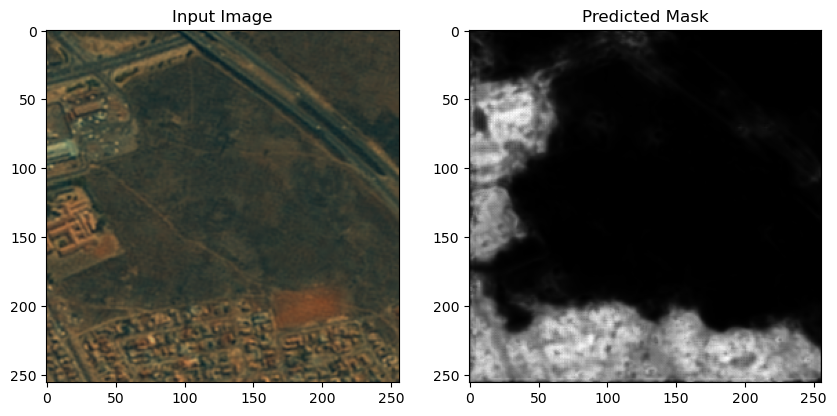

In [48]:
# Visualize the input image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].set_title('Input Image')
axes[1].imshow(predictions[0]*255, cmap='gray')
axes[1].set_title('Predicted Mask')
plt.show()

In [49]:
# Load a test image
test_image_path = 'C:\\Users\\AKAM\\OneDrive\\Desktop\\Challenge\\data_challenge\\images\\test\\images\\test_00013.png'
img = image.load_img(test_image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make predictions
predictions = model.predict(img_array)

1/1 [==============================] - 1s 1s/step


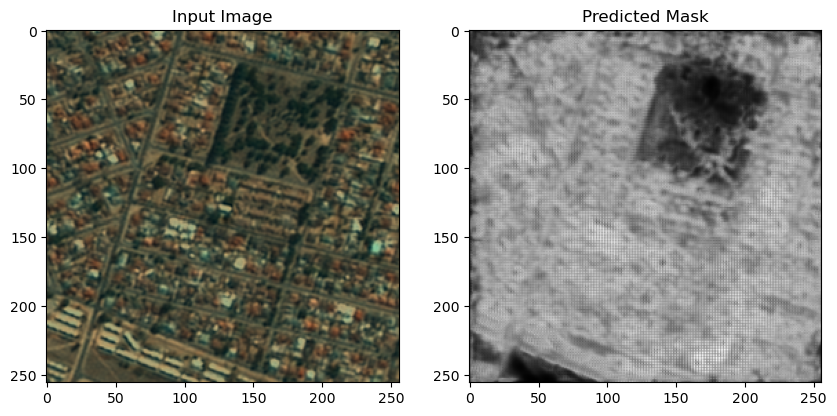

In [50]:
# Visualize the input image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].set_title('Input Image')
axes[1].imshow(predictions[0]*255, cmap='gray')
axes[1].set_title('Predicted Mask')
plt.show()

1/1 [==============================] - 2s 2s/step


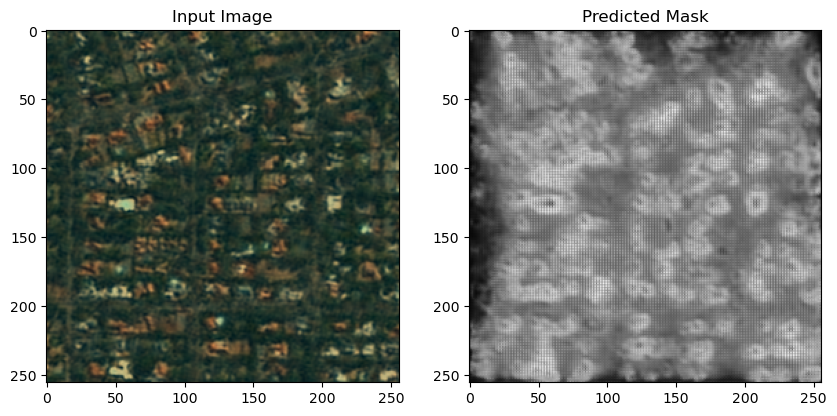

In [97]:
# Load a test image
test_image_path = 'C:\\Users\\AKAM\\OneDrive\\Desktop\\Challenge\\data_challenge\\images\\test\\images\\test_00063.png'
img = image.load_img(test_image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Make predictions
predictions = model.predict(img_array)
# predictions=np.argmax(predictions, axis=-1)
# Visualize the input image and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img)
axes[0].set_title('Input Image')
axes[1].imshow(predictions[0]*255, cmap='gray')
axes[1].set_title('Predicted Mask')
plt.show()